Headline Length Statistics:
 count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


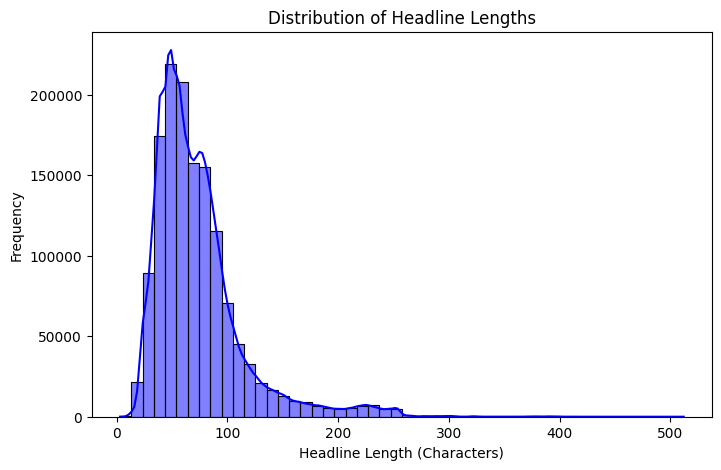

Number of Articles per Publisher (Top 5):
 publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Name: count, dtype: int64


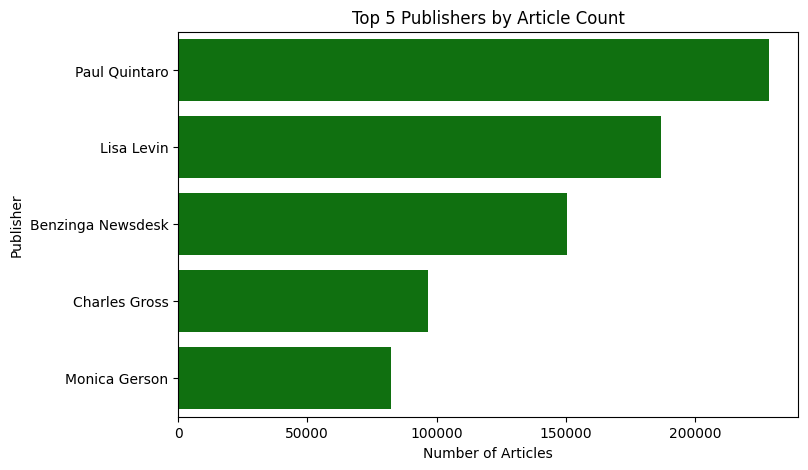

Publication Date Counts (Top 5):
 publication_date
2011-04-27    1
2011-04-28    2
2011-04-29    2
2011-04-30    1
2011-05-01    1
Name: count, dtype: int64


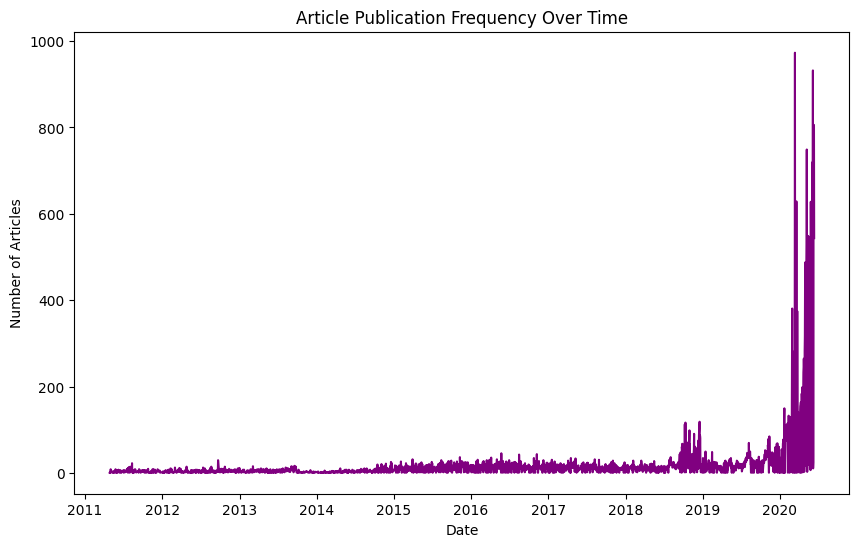

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def load_data():
    """Load the dataset and return a DataFrame."""
    file_path = "C:\\Users\\HP\\10 Acadamy PRojects\\New folder (1)\\News-sentiment-price-prediction\\data\\raw_analyst_ratings.csv"
    df = pd.read_csv(file_path)
    return df

def descriptive_statistics(df, output_dir="plots/"):
    """Perform descriptive statistics on the dataset and show plots."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Headline length statistics
    df['headline_length'] = df['headline'].apply(len)
    print("Headline Length Statistics:\n", df['headline_length'].describe())

    # Plot headline length distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(df['headline_length'], bins=50, kde=True, color='blue')
    plt.title('Distribution of Headline Lengths')
    plt.xlabel('Headline Length (Characters)')
    plt.ylabel('Frequency')
    plt.show()  # Show the plot
    plt.savefig(os.path.join(output_dir, 'headline_length_distribution.png'))
    plt.close()

    # Articles per publisher
    publisher_counts = df['publisher'].value_counts()
    print("Number of Articles per Publisher (Top 5):\n", publisher_counts.head())

    # Plot top publishers
    plt.figure(figsize=(8, 5))
    sns.barplot(x=publisher_counts.head().values, y=publisher_counts.head().index, color='green')
    plt.title('Top 5 Publishers by Article Count')
    plt.xlabel('Number of Articles')
    plt.ylabel('Publisher')
    plt.show()  # Show the plot
    plt.savefig(os.path.join(output_dir, 'top_publishers.png'))
    plt.close()

    # Publication date trends
    df['publication_date'] = pd.to_datetime(df['date'], errors='coerce').dt.date
    date_counts = df['publication_date'].value_counts().sort_index()
    print("Publication Date Counts (Top 5):\n", date_counts.head())

    # Plot publication frequency over time
    plt.figure(figsize=(10, 6))
    date_counts.plot(kind='line', color='purple')
    plt.title('Article Publication Frequency Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Articles')
    plt.show()  # Show the plot
    plt.savefig(os.path.join(output_dir, 'publication_frequency.png'))
    plt.close()

if __name__ == "__main__":
    df = load_data()
    descriptive_statistics(df)


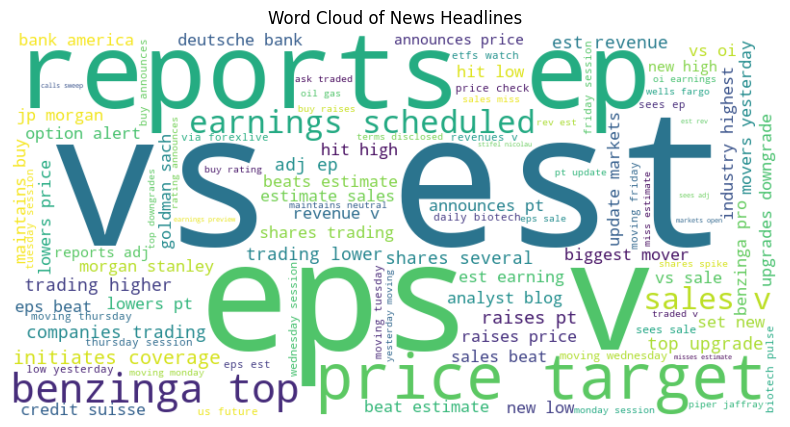


Top words for each topic:
Topic 1: new, deal, lower, higher, announces, oil, companies, trading, says, shares
Topic 2: trading, sales, higher, movers, yesterday, new, biggest, estimate, update, shares
Topic 3: wednesday, hit, thursday, etfs, watch, scheduled, benzinga, moving, session, earnings
Topic 4: option, alert, adj, revenue, sees, sales, reports, eps, est, vs
Topic 5: initiates, announces, raises, maintains, price, target, upgrades, downgrades, buy, pt

Headlines with 'FDA/approval': 15183
Headlines with 'price target': 47634


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import os

# Ensure NLTK resources are downloaded
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
except Exception as e:
    print(f"Error downloading NLTK resources: {e}")

def load_data():
    """Load the dataset and return a DataFrame."""
    file_path = "C:\\Users\\HP\\10 Acadamy PRojects\\New folder (1)\\News-sentiment-price-prediction\\data\\raw_analyst_ratings.csv"
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

def text_analysis(df, output_dir="plots/"):
    """Perform text analysis and topic modeling on headlines."""
    if df is None:
        print("Error: DataFrame is None. Cannot perform text analysis.")
        return

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Handle missing or invalid headlines
    df['headline'] = df['headline'].fillna('').astype(str)

    # Preprocess headlines
    stop_words = set(stopwords.words('english') + ['stock', 'stocks', 'company', 'market'])
    def clean_headline(text):
        tokens = word_tokenize(text)
        cleaned = [word.lower() for word in tokens if word.lower() not in stop_words and word.isalpha()]
        return ' '.join(cleaned)

    df['clean_headline'] = df['headline'].apply(clean_headline)

    # Word cloud
    all_text = ' '.join(df['clean_headline'])
    if all_text.strip():
        wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of News Headlines')
        plt.show()  # Show the word cloud
        plt.savefig(os.path.join(output_dir, 'wordcloud.png'))
        plt.close()
    else:
        print("Warning: No valid text for word cloud generation.")

    # Topic modeling with LDA
    try:
        vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
        X = vectorizer.fit_transform(df['clean_headline'])
        if X.shape[0] > 0 and X.shape[1] > 0:
            lda = LatentDirichletAllocation(n_components=5, random_state=42)
            lda.fit(X)
            feature_names = vectorizer.get_feature_names_out()
            print("\nTop words for each topic:")
            for topic_idx, topic in enumerate(lda.components_):
                top_words = [feature_names[i] for i in topic.argsort()[-10:]]
                print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")
        else:
            print("Warning: No valid documents for LDA after vectorization.")
    except Exception as e:
        print(f"Error in LDA topic modeling: {e}")

    # FDA and price target mentions
    fda_count = df['headline'].str.contains('FDA|fda|approval', case=False, na=False).sum()
    price_target_count = df['headline'].str.contains('price target', case=False, na=False).sum()
    print(f"\nHeadlines with 'FDA/approval': {fda_count}")
    print(f"Headlines with 'price target': {price_target_count}")

if __name__ == "__main__":
    df = load_data()
    text_analysis(df)


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def load_data():
    """Load the dataset and return a DataFrame."""
    file_path = "C:\\Users\\HP\\10 Acadamy PRojects\\New folder (1)\\News-sentiment-price-prediction\\data\\raw_analyst_ratings.csv"
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

def time_series_analysis(df, output_dir="plots/"):
    """Analyze the publication frequency of news headlines over time."""
    if df is None:
        print("Error: DataFrame is None. Cannot perform time series analysis.")
        return

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Check and parse the date column
    if 'date' not in df.columns:
        print("Error: No 'date' column found in the DataFrame.")
        return

    # Convert to datetime, handle errors
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # Drop rows with invalid dates
    df = df.dropna(subset=['date'])

    # Group by date to get publication frequency
    daily_counts = df.groupby(df['date'].dt.date).size()

    # Plot daily publication frequency
    plt.figure(figsize=(12, 6))
    daily_counts.plot(kind='line', marker='o', color='tab:blue')
    plt.xlabel('Date')
    plt.ylabel('Number of Articles')
    plt.title('Daily Publication Frequency of News Articles')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.savefig(os.path.join(output_dir, 'daily_publication_frequency.png'))
    plt.close()
    print("Daily publication frequency plot saved.")

    # Check for weekly patterns
    df['day_of_week'] = df['date'].dt.day_name()
    weekly_counts = df['day_of_week'].value_counts().reindex([
        'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
    ])

    plt.figure(figsize=(10, 5))
    sns.barplot(x=weekly_counts.index, y=weekly_counts.values, palette='viridis')
    plt.xlabel('Day of the Week')
    plt.ylabel('Number of Articles')
    plt.title('Publication Frequency by Day of the Week')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'weekly_publication_frequency.png'))
    plt.close()
    print("Weekly publication frequency plot saved.")

    # Detect spikes (threshold = mean + 2*std)
    mean_count = daily_counts.mean()
    std_count = daily_counts.std()
    spike_threshold = mean_count + 2 * std_count
    spikes = daily_counts[daily_counts > spike_threshold]

    if not spikes.empty:
        print(f"Spikes detected on the following dates:\n{spikes}")
    else:
        print("No significant spikes detected in publication frequency.")

if __name__ == "__main__":
    df = load_data()
    time_series_analysis(df)


Daily publication frequency plot saved.


C:\Users\HP\AppData\Local\Temp\ipykernel_17944\3281076188.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week'] = df['date'].dt.day_name()
C:\Users\HP\AppData\Local\Temp\ipykernel_17944\3281076188.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekly_counts.index, y=weekly_counts.values, palette='viridis')


Weekly publication frequency plot saved.
Spikes detected on the following dates:
date
2020-02-27    275
2020-02-28    381
2020-03-06    281
2020-03-11    282
2020-03-12    973
2020-03-19    629
2020-03-23    375
2020-03-24    160
2020-04-09    164
2020-04-13    184
2020-04-15    186
2020-04-16    199
2020-04-17    194
2020-04-20    180
2020-04-21    233
2020-04-22    245
2020-04-23    265
2020-04-24    246
2020-04-27    283
2020-04-28    317
2020-04-29    449
2020-04-30    488
2020-05-01    385
2020-05-04    347
2020-05-05    478
2020-05-06    531
2020-05-07    749
2020-05-08    508
2020-05-11    485
2020-05-12    387
2020-05-13    549
2020-05-14    536
2020-05-15    322
2020-05-18    547
2020-05-19    332
2020-05-20    461
2020-05-21    333
2020-05-22    286
2020-05-26    628
2020-05-27    492
2020-05-28    465
2020-05-29    309
2020-06-01    484
2020-06-02    361
2020-06-03    720
2020-06-04    538
2020-06-05    932
2020-06-08    765
2020-06-09    804
2020-06-10    806
2020-06-11    

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def load_data():
    """Load the dataset and return a DataFrame."""
    file_path = "C:\\Users\\HP\\10 Acadamy PRojects\\New folder (1)\\News-sentiment-price-prediction\\data\\raw_analyst_ratings.csv"
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

def publisher_analysis(df, output_dir="plots/"):
    """Analyze publisher activity and the types of news they report."""
    if df is None:
        print("Error: DataFrame is None. Cannot perform publisher analysis.")
        return

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    if 'publisher' not in df.columns:
        print("Error: No 'publisher' column found in the DataFrame.")
        return

    # Calculate publisher counts
    publisher_counts = df['publisher'].value_counts()
    print("Top 5 Publishers:\n", publisher_counts.head())

    # Plot top 5 publishers
    plt.figure(figsize=(8, 5))
    sns.barplot(x=publisher_counts.head().values, y=publisher_counts.head().index, color='tab:green')
    plt.xlabel('Number of Articles')
    plt.ylabel('Publisher')
    plt.title('Top 5 Publishers by Article Count')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'top_publishers.png'))
    plt.close()
    print("Top publishers plot saved.")

    # Check for email addresses and extract unique domains
    df['is_email'] = df['publisher'].str.contains(r'@', na=False)
    if df['is_email'].any():
        df['domain'] = df.loc[df['is_email'], 'publisher'].str.split('@').str[1]
        domain_counts = df['domain'].value_counts()
        print("Top 5 Domains:\n", domain_counts.head())

        # Plot top 5 email domains
        plt.figure(figsize=(8, 5))
        sns.barplot(x=domain_counts.head().values, y=domain_counts.head().index, color='tab:purple')
        plt.xlabel('Number of Articles')
        plt.ylabel('Domain')
        plt.title('Top 5 Domains (Email Publishers)')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'top_email_domains.png'))
        plt.close()
        print("Top email domains plot saved.")
    else:
        print("No email addresses found in publisher names.")

    # Categorize news types
    def categorize_news(headline):
        headline_lower = headline.lower()
        if 'earning' in headline_lower:
            return 'Earnings'
        elif 'price target' in headline_lower:
            return 'Price Target'
        elif 'fda' in headline_lower:
            return 'FDA'
        else:
            return 'Other'

    df['news_type'] = df['headline'].apply(lambda x: categorize_news(str(x)))
    news_type_counts = df['news_type'].value_counts()
    print("News Type Distribution:\n", news_type_counts)

    # Plot news types by top publishers
    top_publishers = publisher_counts.head().index
    news_type_by_publisher = df[df['publisher'].isin(top_publishers)].groupby(['publisher', 'news_type']).size().unstack(fill_value=0)

    news_type_by_publisher.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set2')
    plt.xlabel('Publisher')
    plt.ylabel('Number of Articles')
    plt.title('News Types Reported by Top Publishers')
    plt.legend(title='News Type')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'news_types_by_publisher.png'))
    plt.close()
    print("News types by top publishers plot saved.")

if __name__ == "__main__":
    df = load_data()
    publisher_analysis(df)


Top 5 Publishers:
 publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Name: count, dtype: int64
Top publishers plot saved.
Top 5 Domains:
 domain
benzinga.com      7937
gmail.com          139
andyswan.com         5
investdiva.com       2
tothetick.com        2
Name: count, dtype: int64
Top email domains plot saved.
News Type Distribution:
 news_type
Other           1261605
Earnings          87562
Price Target      47457
FDA               10704
Name: count, dtype: int64
News types by top publishers plot saved.
